In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data as data_utils


In [16]:
!pip install yfinance

In [17]:

import pandas as pd
import numpy as np
import os.path
from functools import reduce

import datetime, time, os, requests, torch
import yfinance as yf
from bs4 import BeautifulSoup as BS

import warnings
warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Using cpu device


In [18]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import torch
import requests
import yfinance as yf
from bs4 import BeautifulSoup as BS

class MyDataset:
    def __init__(self, device='cpu'):
        self.url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        self.stocks_fname = "sp500_closefull.csv"
        self.start = datetime.datetime(2010, 1, 1)
        self.stop = datetime.datetime.now()
        self.Ntest = 1000
        self.now = time.time()
        self.device = device

    # ---------- Utilities ----------

    def _get_sp500_tickers(self):
        """Fetch S&P 500 tickers from Wikipedia."""
        print("➡️ Fetching S&P 500 tickers...")
        headers = {'User-Agent': 'Mozilla/5.0'}
        resp = requests.get(self.url, headers=headers, timeout=30, verify=False)
        resp.raise_for_status()
        tables = pd.read_html(resp.text, attrs={'id': 'constituents'})
        if len(tables) == 0:
            raise RuntimeError("Could not find the S&P 500 table with id='constituents'.")
        df = tables[0]
        tickers = df['Symbol'].astype(str).str.replace('.', '-', regex=False).tolist()
        print(f"✅ Found {len(tickers)} tickers.")
        return tickers

    def _flatten_and_pick_spy(self, df: pd.DataFrame):
        """
        Make sure columns are flat strings and robustly find the SPY column name.
        Returns (flat_df, spy_col_name).
        """
        # Flatten tuples / MultiIndex → strings
        if isinstance(df.columns, pd.MultiIndex) or any(isinstance(c, tuple) for c in df.columns):
            df = df.copy()
            df.columns = ["_".join(map(str, c)).strip("_") if isinstance(c, tuple) else str(c) for c in df.columns]
        else:
            df.columns = [str(c) for c in df.columns]

        # Try strict 'SPY' first
        cands = [c for c in df.columns if c.upper() == "SPY"]
        # Common patterns from yfinance/concat: 'SPY_SPY', 'Close_SPY', 'SPY_Close'
        if not cands:
            cands = [c for c in df.columns if "SPY" in c.upper().split("_")]
        if not cands:
            cands = [c for c in df.columns if "SPY" in c.upper()]

        if not cands:
            sample = ", ".join(list(df.columns)[-10:])
            raise KeyError(f"SPY column not found. Columns tail: {sample}")

        return df, cands[0]

    # ---------- Main pipeline ----------

    def get_train_test(self, top_k_features=100):
        """
        Build a leakage-free binary classification dataset:
        - Target is SPY(t+1) > 0
        - Features are cross-sectional returns at t-1 (lagged by 1 day)
        - Temporal split: train / val / test (no shuffle)
        - Optional: keep only top_k_features by variance to reduce dimensionality
        Returns: (train_labels, train_features, val_labels, val_features, test_labels, test_features)
        """
        start, end = self.start, self.stop

        # 1) Download or load cached closes (wide: columns=tickers)
        if not os.path.isfile(self.stocks_fname):
            tickers = self._get_sp500_tickers()
            print("➡️ Downloading all S&P 500 stocks (auto_adjust=True)...")
            data = yf.download(
                tickers, start=start, end=end,
                auto_adjust=True, group_by='ticker',
                progress=True, threads=True
            )
            # data has MultiIndex (field, ticker) → extract Close by ticker
            close = data.stack(level=0)['Close'].unstack(level=1)
            close.to_csv(self.stocks_fname)
            print(f"✅ Saved cache to {self.stocks_fname}")
        else:
            print(f"ℹ️ Using cached file {self.stocks_fname}")

        df_feat = pd.read_csv(self.stocks_fname, index_col=0, parse_dates=True)
        print(f"📦 Feature price frame: {df_feat.shape}")

        # 2) SPY closes (download separately)
        print("➡️ Downloading SPY...")
        df_spy = yf.download("SPY", start=start, end=end, auto_adjust=True, progress=False)
        # Keep a single 'SPY' column; name may get altered after concat → we detect later anyway
        if 'Close' in df_spy.columns:
            df_spy = df_spy[['Close']].rename(columns={'Close': 'SPY'})
        elif 'Adj Close' in df_spy.columns:
            df_spy = df_spy[['Adj Close']].rename(columns={'Adj Close': 'SPY'})
        else:
            raise RuntimeError("SPY download missing Close/Adj Close.")
        print(f"✅ SPY shape: {df_spy.shape}")

        # 3) Merge, fill, drop empty
        df_all = pd.concat([df_feat, df_spy], axis=1).ffill().bfill().dropna(how='all')

        # 3.1) Flatten & robustly find the SPY column name
        df_all, spy_col = self._flatten_and_pick_spy(df_all)
        print(f"✅ Combined shape: {df_all.shape} | target column = '{spy_col}'")

        # 4) Returns with correct temporal logic
        rets = np.log(df_all).diff()

        # Target = tomorrow's SPY sign
        y = (rets[spy_col].shift(-1) > 0).astype(int)

        # Features = cross-sectional returns lagged by 1 day (exclude SPY to avoid leakage)
        X = rets.drop(columns=[spy_col]).shift(1)

        # 5) Align and drop NaNs consistently
        df_xy = pd.concat([X, y.rename('TARGET')], axis=1).dropna()
        X = df_xy.drop(columns=['TARGET'])
        y = df_xy['TARGET'].astype(int)
        print(f"✅ After alignment: X={X.shape}, y={y.shape}")

        # 6) (Optional) reduce dimensionality by keeping top-K most volatile tickers
        if top_k_features is not None and X.shape[1] > top_k_features:
            var = X.var().sort_values(ascending=False)
            keep_cols = var.index[:top_k_features]
            X = X[keep_cols]
            print(f"🔎 Kept top-{top_k_features} features by variance. New X shape: {X.shape}")

        # 7) Temporal split: 70/15/15 (train / val / test)
        N = len(y)
        i1 = int(N * 0.70)
        i2 = int(N * 0.85)
        X_train, y_train = X.iloc[:i1], y.iloc[:i1]
        X_val,   y_val   = X.iloc[i1:i2], y.iloc[i1:i2]
        X_test,  y_test  = X.iloc[i2:],   y.iloc[i2:]

        # 8) Standardize using TRAIN stats only (no sklearn needed)
        mu = X_train.mean()
        sd = X_train.std().replace(0, 1.0)  # guard against zero std

        def zscore(Z): return (Z - mu) / sd
        X_train = zscore(X_train)
        X_val   = zscore(X_val)
        X_test  = zscore(X_test)

        # 9) Convert to tensors (labels as float in {0,1}, shape (N,1))
        toX = lambda a: torch.tensor(a.values, dtype=torch.float32).to(self.device)
        toy = lambda a: torch.tensor(a.values, dtype=torch.float32).unsqueeze(1).to(self.device)

        train_features, train_labels = toX(X_train), toy(y_train)
        val_features,   val_labels   = toX(X_val),   toy(y_val)
        test_features,  test_labels  = toX(X_test),  toy(y_test)

        print("📊 Split sizes —", f"train={len(train_labels)}  val={len(val_labels)}  test={len(test_labels)}")
        print("📐 Feature dim:", train_features.shape[1])

        # Return in clear order: train, val, test
        return train_labels, train_features, val_labels, val_features, test_labels, test_features


In [19]:
dataset = MyDataset()
train_labels, train_features, test_labels, test_features, val_labels, val_features = dataset.get_train_test()

ℹ️ Using cached file sp500_closefull.csv
📦 Feature price frame: (3985, 483)
➡️ Downloading SPY...
✅ SPY shape: (3985, 1)
✅ Combined shape: (3985, 484) | target column = 'SPY_SPY'
✅ After alignment: X=(3983, 483), y=(3983,)
🔎 Kept top-100 features by variance. New X shape: (3983, 100)
📊 Split sizes — train=2788  val=597  test=598
📐 Feature dim: 100


In [20]:
train_labels.shape, train_labels.shape, val_labels.shape, val_features.shape

(torch.Size([2788, 1]),
 torch.Size([2788, 1]),
 torch.Size([598, 1]),
 torch.Size([598, 100]))

In [21]:
pd.Series(train_labels.squeeze(1).numpy()).value_counts()

1.0    1555
0.0    1233
Name: count, dtype: int64

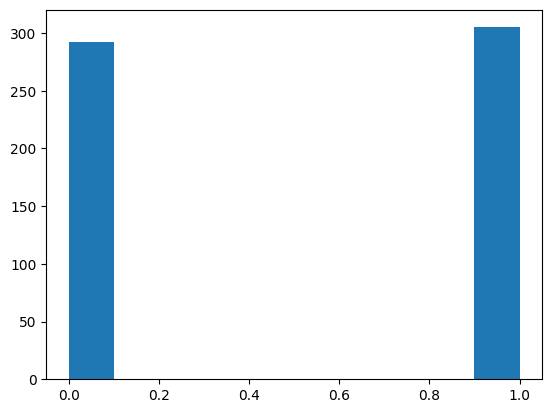

In [22]:
plt.hist(test_labels.squeeze(1).numpy());

In [23]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 16

# --- create datasets ---
train_data = TensorDataset(train_features, train_labels)
val_data   = TensorDataset(val_features,   val_labels)
test_data  = TensorDataset(test_features,  test_labels)  # <-- тут была опечатка!

# --- create loaders ---
# ❗ for time-series classification we usually DO NOT shuffle validation/test
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

# quick sanity check
for X, y in train_dataloader:
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)
    break


Shape of X: torch.Size([16, 100])
Shape of y: torch.Size([16, 1])


In [24]:
import torch
import torch.nn as nn

# Parameterize input dim so it matches your feature matrix
class NeuralNetwork(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)     # logits for BCEWithLogitsLoss
        )
    def forward(self, x):
        return self.net(x)       # returns logits (no sigmoid here)

def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss, n = 0.0, 0
    for X, y in dataloader:
        X = X.to(device, dtype=torch.float32)
        # Ensure labels are float (0/1) and shape (N,1)
        y = y.to(device).float().view(-1, 1)

        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        # (optional) gradient clipping for stability
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        bs = X.size(0)
        total_loss += loss.item() * bs
        n += bs
    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    total_loss, n = 0.0, 0
    correct = 0
    for X, y in dataloader:
        X = X.to(device, dtype=torch.float32)
        y = y.to(device).float().view(-1, 1)

        logits = model(X)
        loss = loss_fn(logits, y)

        # Convert logits to probabilities, then to 0/1
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        correct += (preds.eq(y)).sum().item()

        bs = X.size(0)
        total_loss += loss.item() * bs
        n += bs
    avg_loss = total_loss / max(n, 1)
    acc = correct / max(n, 1)
    return avg_loss, acc

# ---- wiring ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d_in = X.data.shape[1]  # set to your feature dimension (X.shape[1])

model = NeuralNetwork(d_in).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# (optional) scheduler per-epoch, not per-batch
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

epochs = 10
best_val_acc, best_state = 0.0, None
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(val_dataloader, model, loss_fn, device)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.3f}")
    if val_acc > best_val_acc:
        best_val_acc, best_state = val_acc, {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    scheduler.step()

# Restore best on val
if best_state:
    model.load_state_dict(best_state)

# Final test
test_loss, test_acc = evaluate(test_dataloader, model, loss_fn, device)
print(f"Test: loss={test_loss:.4f} | acc={test_acc:.3f}")


Epoch 01 | train_loss=0.6934 | val_loss=0.6873 | val_acc=0.540
Epoch 02 | train_loss=0.6794 | val_loss=0.6964 | val_acc=0.528
Epoch 03 | train_loss=0.6648 | val_loss=0.7160 | val_acc=0.527
Epoch 04 | train_loss=0.6412 | val_loss=0.7560 | val_acc=0.527
Epoch 05 | train_loss=0.6115 | val_loss=0.7495 | val_acc=0.518
Epoch 06 | train_loss=0.5784 | val_loss=0.8399 | val_acc=0.470
Epoch 07 | train_loss=0.5285 | val_loss=1.0001 | val_acc=0.488
Epoch 08 | train_loss=0.4690 | val_loss=1.0922 | val_acc=0.483
Epoch 09 | train_loss=0.4238 | val_loss=1.1874 | val_acc=0.502
Epoch 10 | train_loss=0.3692 | val_loss=1.3064 | val_acc=0.487
Test: loss=0.6979 | acc=0.511


In [25]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

@torch.no_grad()
def eval_metrics(model, dl, threshold):
    model.eval()
    probs, ys = [], []
    for X, y in dl:
        p = torch.sigmoid(model(X.to(device))).cpu().numpy().ravel()
        probs.append(p); ys.append(y.cpu().numpy().ravel())
    probs = np.concatenate(probs); ys = np.concatenate(ys)
    preds = (probs > threshold).astype(int)
    print("acc:", accuracy_score(ys, preds))
    print("bal_acc:", balanced_accuracy_score(ys, preds))
    try:
        print("roc_auc:", roc_auc_score(ys, probs))
    except ValueError:
        pass
    print("confusion:\n", confusion_matrix(ys, preds))


In [26]:
eval_metrics(model, test_dataloader, 0.5)

acc: 0.5108877721943048
bal_acc: 0.5064956209297102
roc_auc: 0.496305861217157
confusion:
 [[ 89 203]
 [ 89 216]]
